In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD ,AdamW

from datasets import load_dataset, load_metric

import matplotlib.pyplot as plt

import json
from statistics import mean

In [2]:
import utils_generic as generic
import multitask_dep as mt
import model_confs as confs
import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tasks = ['to','as','about']

In [4]:
model_conf = confs.bert_conf
encoding_type = 'brk'

# Datos ConvAI

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = mt.Vocabulary(data['train'],encoding_type)

convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [7]:
convai_train_dataset = mt.DatasetMultitaskDep(convai_train_token,tasks,eval=False)
convai_val_dataset = mt.DatasetMultitaskDep(convai_val_token,tasks,eval=False)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 
md_dataset = mt.DatasetMultitaskDep(md_tokenized,tasks,eval=True)

# Creación dataloaders

In [10]:
dl_train =DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_val =DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_eval = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=mt.collate_fn)

# Modelo multitask

In [11]:
num_epochs = 100
learning_rate = 1e-6

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0644656749967916 	 Validation loss: 2.0216768050597884 	 
  1%|          | 574/57400 [01:47<2:44:02,  5.77it/s]
Epoch 2 	 Training loss: 2.0007752115718165 	 Validation loss: 1.9955547765149908 	 
  2%|▏         | 1148/57400 [03:29<2:30:30,  6.23it/s]
Epoch 3 	 Training loss: 1.9806711158685983 	 Validation loss: 1.99008531893714 	 
  3%|▎         | 1722/57400 [05:12<2:35:09,  5.98it/s]
Epoch 4 	 Training loss: 1.9710374513984972 	 Validation loss: 1.9804895813182248 	 
  4%|▍         | 2296/57400 [06:55<2:52:10,  5.33it/s]
Epoch 5 	 Training loss: 1.967207769691321 	 Validation loss: 1.9729353472337885 	 
  5%|▌         | 2870/57400 [08:37<2:29:05,  6.10it/s]
Epoch 6 	 Training loss: 1.9616634035775056 	 Validation loss: 1.9631782850976718 	 
  6%|▌         | 3444/57400 [10:19<2:23:44,  6.26it/s]
Epoch 7 	 Training loss: 1.9601954589322053 	 Validation loss: 1.9745557712296309 	 

1 epoch without improvement
  7%|▋         | 4018/57400 [12:02<2:47:43,  5.30i

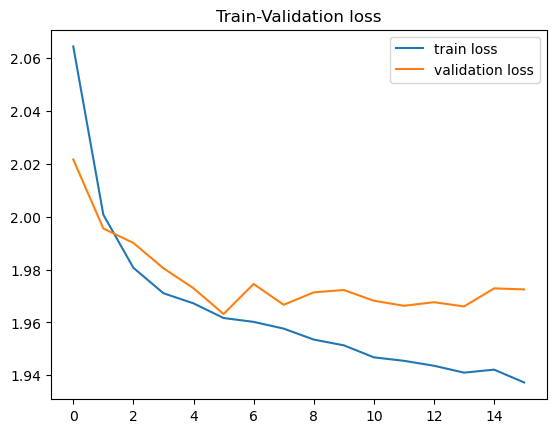

In [12]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='bert_multitask_brk_1'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [12]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load('bert_multitask_brk_1'))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.6755050505050505, 'precision': 0.6755050505050505, 'f1': 0.6755050505050505, 'accuracy': 0.6755050505050505}, 'as': {'recall': 0.7144719687092569, 'precision': 0.7144719687092569, 'f1': 0.7144719687092569, 'accuracy': 0.7144719687092569}, 'about': {'recall': 0.8214285714285714, 'precision': 0.8214285714285714, 'f1': 0.8214285714285714, 'accuracy': 0.8214285714285714}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7274939172749392, 'precision': 0.7274939172749392, 'f1': 0.7274939172749392, 'accuracy': 0.7274939172749392}, 'as': {'recall': 0.7373737373737373, 'precision': 0.7373737373737373, 'f1': 0.7373737373737375, 'accuracy': 0.7373737373737373}, 'about': {'recall': 0.8541666666666666, 'precision': 0.8541666666666666, 'f1': 0.8541666666666666, 'accuracy': 0.8541666666666666}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6194225721784777, 'precision': 0.6194225721784777, 'f1': 0.6194225721784777, 'accuracy': 0.6194225721784777}, 'a

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0591281243317634 	 Validation loss: 2.013973985688161 	 
  1%|          | 574/57400 [01:40<2:38:56,  5.96it/s]
Epoch 2 	 Training loss: 1.9971172664223649 	 Validation loss: 1.9881069963261233 	 
  2%|▏         | 1148/57400 [03:20<2:13:21,  7.03it/s]
Epoch 3 	 Training loss: 1.9793878095905955 	 Validation loss: 1.9868216635817189 	 
  3%|▎         | 1722/57400 [05:00<2:51:06,  5.42it/s]
Epoch 4 	 Training loss: 1.9723434510546693 	 Validation loss: 1.9804610902980222 	 
  4%|▍         | 2296/57400 [06:41<2:36:48,  5.86it/s]
Epoch 5 	 Training loss: 1.964684993547845 	 Validation loss: 1.9772499941163144 	 
  5%|▌         | 2870/57400 [08:22<2:37:28,  5.77it/s]
Epoch 6 	 Training loss: 1.9620865683107012 	 Validation loss: 1.973017478393296 	 
  6%|▌         | 3444/57400 [10:02<2:43:22,  5.50it/s]
Epoch 7 	 Training loss: 1.9582449797969246 	 Validation loss: 1.9689805790529413 	 
  7%|▋         | 4018/57400 [11:42<2:22:03,  6.26it/s]
Epoch 8 	 Training loss:

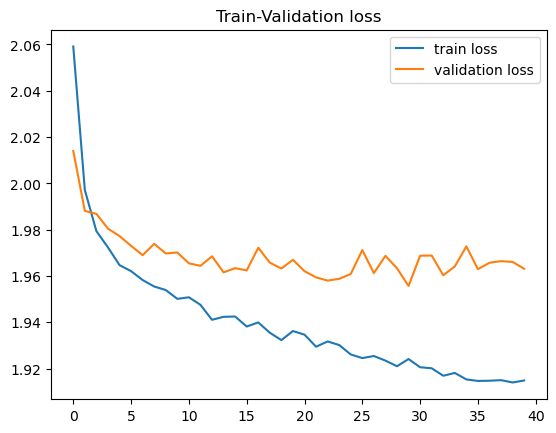

In [14]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='bert_multitask_brk_2'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [13]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load('bert_multitask_brk_3'))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.6982323232323232, 'precision': 0.6982323232323232, 'f1': 0.6982323232323232, 'accuracy': 0.6982323232323232}, 'as': {'recall': 0.727509778357236, 'precision': 0.727509778357236, 'f1': 0.727509778357236, 'accuracy': 0.727509778357236}, 'about': {'recall': 0.8354591836734694, 'precision': 0.8354591836734694, 'f1': 0.8354591836734694, 'accuracy': 0.8354591836734694}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7347931873479319, 'precision': 0.7347931873479319, 'f1': 0.7347931873479319, 'accuracy': 0.7347931873479319}, 'as': {'recall': 0.73989898989899, 'precision': 0.73989898989899, 'f1': 0.73989898989899, 'accuracy': 0.73989898989899}, 'about': {'recall': 0.8541666666666666, 'precision': 0.8541666666666666, 'f1': 0.8541666666666666, 'accuracy': 0.8541666666666666}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6587926509186351, 'precision': 0.6587926509186351, 'f1': 0.6587926509186351, 'accuracy': 0.6587926509186351}, 'as': {'recall

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0518648946326783 	 Validation loss: 2.016511904991279 	 
  1%|          | 574/57400 [01:42<2:41:01,  5.88it/s]
Epoch 2 	 Training loss: 1.991614246825308 	 Validation loss: 1.991076069363093 	 
  2%|▏         | 1148/57400 [03:22<2:15:44,  6.91it/s]
Epoch 3 	 Training loss: 1.9742871093002345 	 Validation loss: 1.9833558939271054 	 
  3%|▎         | 1722/57400 [05:02<2:27:49,  6.28it/s]
Epoch 4 	 Training loss: 1.9670532975047308 	 Validation loss: 1.9805250693175753 	 
  4%|▍         | 2296/57400 [06:47<2:37:35,  5.83it/s]
Epoch 5 	 Training loss: 1.9633782979503327 	 Validation loss: 1.9708269955748219 	 
  5%|▌         | 2870/57400 [08:34<2:20:46,  6.46it/s]
Epoch 6 	 Training loss: 1.9600447522223203 	 Validation loss: 1.9740878666861583 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [10:20<2:13:43,  6.73it/s]
Epoch 7 	 Training loss: 1.958570057299079 	 Validation loss: 1.9726908853498555 	 

2 epoch without improvement
  7%|▋         | 4018/

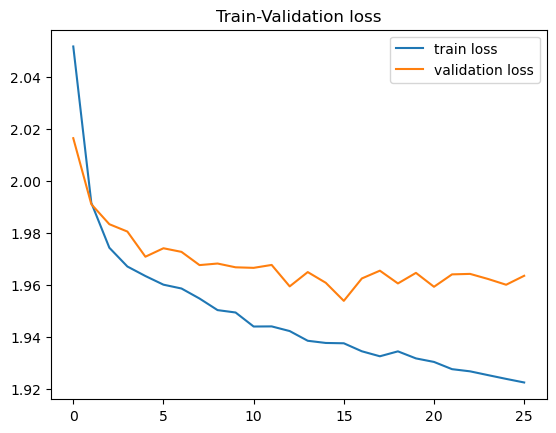

In [14]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='bert_multitask_brk_3'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [15]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.6957070707070707, 'precision': 0.6957070707070707, 'f1': 0.6957070707070707, 'accuracy': 0.6957070707070707}, 'as': {'recall': 0.7196870925684485, 'precision': 0.7196870925684485, 'f1': 0.7196870925684485, 'accuracy': 0.7196870925684485}, 'about': {'recall': 0.8392857142857143, 'precision': 0.8392857142857143, 'f1': 0.8392857142857143, 'accuracy': 0.8392857142857143}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7128953771289538, 'precision': 0.7128953771289538, 'f1': 0.7128953771289537, 'accuracy': 0.7128953771289538}, 'as': {'recall': 0.7222222222222222, 'precision': 0.7222222222222222, 'f1': 0.7222222222222222, 'accuracy': 0.7222222222222222}, 'about': {'recall': 0.8411458333333334, 'precision': 0.8411458333333334, 'f1': 0.8411458333333333, 'accuracy': 0.8411458333333334}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6771653543307087, 'precision': 0.6771653543307087, 'f1': 0.6771653543307087, 'accuracy': 0.6771653543307087}, 'a

In [16]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.8320578231292517, 'precision': 0.8320578231292517, 'f1': 0.8320578231292517, 'accuracy': 0.8320578231292517}
Métricas etiqueta male: {'recall': 0.8498263888888888, 'precision': 0.8498263888888888, 'f1': 0.8498263888888888, 'accuracy': 0.8498263888888888}
Métricas etiqueta female:  {'recall': 0.8150000000000001, 'precision': 0.8150000000000001, 'f1': 0.8150000000000001, 'accuracy': 0.8150000000000001}

 to
Resultado global: {'recall': 0.6898148148148148, 'precision': 0.6898148148148148, 'f1': 0.6898148148148148, 'accuracy': 0.6898148148148148}
Métricas etiqueta male: {'recall': 0.7250608272506083, 'precision': 0.7250608272506083, 'f1': 0.7250608272506083, 'accuracy': 0.7250608272506083}
Métricas etiqueta female:  {'recall': 0.6517935258092739, 'precision': 0.6517935258092739, 'f1': 0.6517935258092739, 'accuracy': 0.6517935258092739}

 as
Resultado global: {'recall': 0.7205562798783138, 'precision': 0.7205562798783138, 'f1': 0.7